In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
from sparse_kernel_logistic import KernelLogisticRegression

## Abstract

In this blog post, I implemented a sparse kernel logistic regression model. This model uses a kernel function to allow logistic regression to learn nonlinear patterns, and it uses $\ell_1$ regularization to make the model sparse by setting many weights to zero. 

I did many experiments to show and learn how the model behaves: I show how a large regularization strength (λ) makes the model sparse, how changing the kernel parameter (γ) affects the decision boundary, and alsohow the model can fit nonlinear data like the `make_moons` dataset. Finally, I showed an example of overfitting by using a high γ and comparing training and testing performance with ROC curves.

## Sparse Kernel Logistic Regression Implementation

For the implementation of my [sparse_kernel_logistic.py](https://github.com/Pbabu-Github/csci-0451/blob/main/posts/Kernel_Machines/sparse_kernel_logistic.py) where I implemented a custom logistic regression model that works in kernel space instead of feature space. This is different from regular logistic regression because instead of learning a weight vector $w$, we learn a vector of dual weights $a$ and use a kernel function to compute scores.

In my KernelLogisticRegression class I had the following function:

Score function:
* To predict outputs for new data, the model computes the score
\[
s = K(X, X_{\mathrm{train}})^\top a
\]
where \( K \) is the kernel matrix. This is for the model to make nonlinear decisions too.

Loss function:
* The loss has two parts:
  - The logistic loss.
  - An \(\ell_1\) regularization on the dual weights \(a\) taht helps sparsity by making many entries of \(a\) equal to zero.

Gradient function:
* I calculated the gradient of the total loss, including the gradient of the \(\ell_1\)
* This helps us to calculate the gradient descent.

Fit function:
* Function that trained the model by calculating the kernel matrix, initializing \( a = 0 \), and updating \( a \) with gradient descent for many epochs.

Now lets set up our kernel for our experiments.


In [2]:
def rbf_kernel(X1, X2, gamma):
    return torch.exp(-gamma * torch.cdist(X1, X2)**2)

## Testing our implementaion of our kernellized logistic regression
So in our code below we will generate a simple dataset that is linearly separable adn will be testing our implementation.

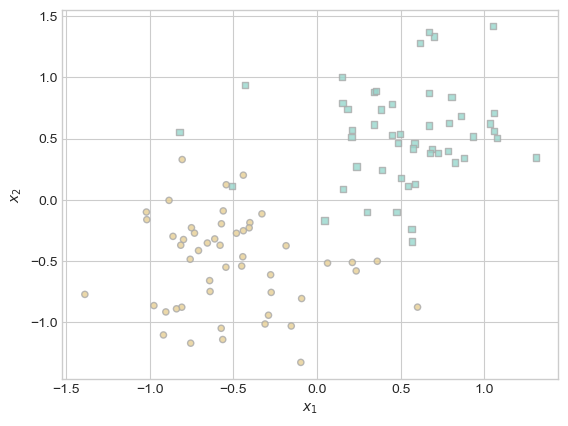

In [3]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

Now that we have set up our dataset and also set up our Kernalized logistic regression, lets finally test it.

In [9]:
from sparse_kernel_logistic import KernelLogisticRegression
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

Lets now look at our vector Kr.a

In [8]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.1000)

Now in our code below we will plot ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍scores ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍along ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with the training data, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍we will also ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍highlight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pieces ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weights that are distinguishable ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍0

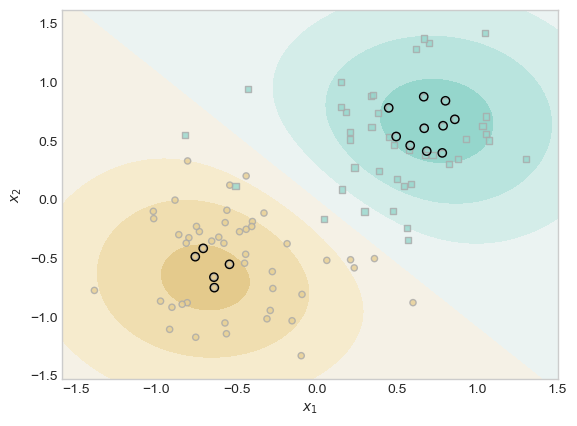

In [10]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

We can see in the plot above that our model separates the two classes with a smooth, curved boundary. Only a some of the training points(the ones with black outline) have large influence on the decision and most other points have little or no effect. The RBF kernel helps create a nonlinear boundary that fits pir data well.

## Part A

### Experiment 1: Effect of Large λ (Sparsity)

In this experiment, I will show how increasing the regularization strength λ causes many entries of the weight vector $a$ to become exactly zero. This is a  feature of sparse models that they only rely on a few "important" training points.

I trained my model with a very large value of λ (i.e. λ = 10). After training, I counted how many entries of $a$ are distinguishable from 0 by checking if they are greater than 0.001 in absolute value.

This expeiremnt showed that the model became extremely sparse. None of the training points had weights greater than 0.001. This means that with such a strong regularization (λ = 10), the model ignored all the training points and didn't form a usable boundary. This shows what happens when regularization is very strong and the model becomes so sparse that it underfits the data which means it is not a good model.


In [11]:
KR = KernelLogisticRegression(rbf_kernel, lam=10.0, gamma=1)
KR.fit(X, y, m_epochs=500000, lr=0.0001)
(1.0 * (KR.a.abs() > 0.001)).mean()

tensor(0.)

### Experiment 2: Effect of γ on the Decision Boundary

For the second experiment I tried experimented with different values of the kernel parameter γ. This parameter controls the "wiggliness" of the decision boundary. A small γ leads to smoother decision boundaries, while large γ results in very wiggly boundaries.

I trained two models with the same λ, but different γ values (γ = 0.1 vs. γ = 10), and plotted their decision boundaries and saw that the model with higher γ produced a much more complex decision boundary. In our plots below we can see both models and how changing γ leads to different boundary behaviors.

In [12]:
# using a Low gamma = smooth
KR_smooth = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=0.1)
KR_smooth.fit(X, y, m_epochs=500000, lr=0.0001)

# experimenting witha High gamma for wiggly
KR_wiggly = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=10)
KR_wiggly.fit(X, y, m_epochs=500000, lr=0.0001)


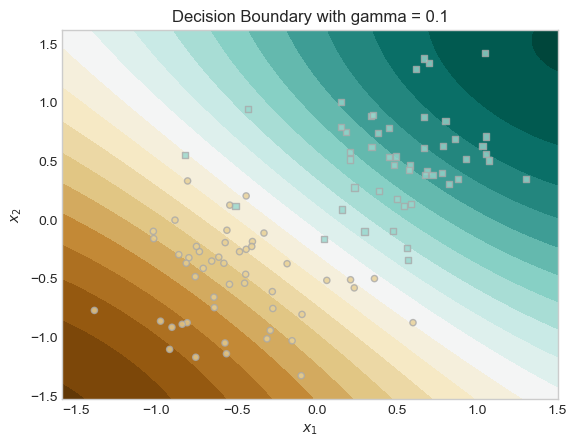

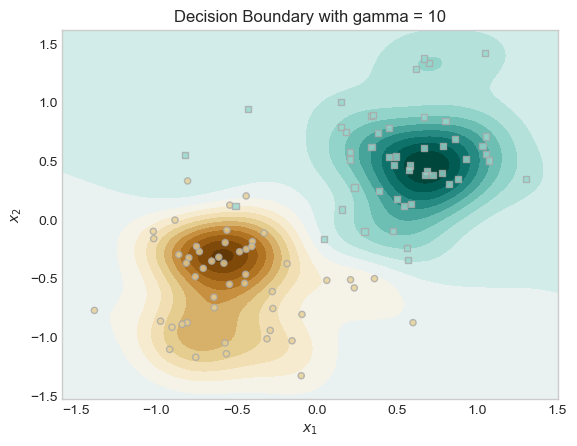

In [16]:
# grid for teh plot for plotting
x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
grid = torch.stack([X1.ravel(), X2.ravel()], dim=1)

# Plot for KR_smooth
preds_smooth = KR_smooth.score(grid, recompute_kernel=True)
preds_smooth = preds_smooth.reshape(X1.shape)

fig, ax = plt.subplots()
ax.contourf(X1, X2, preds_smooth, cmap="BrBG", levels=20)
plot_classification_data(X, y, ax)
ax.set_title("Decision Boundary with gamma = 0.1")
plt.show()

# plot for KR_wiggly
preds_wiggly = KR_wiggly.score(grid, recompute_kernel=True)
preds_wiggly = preds_wiggly.reshape(X1.shape)

fig, ax = plt.subplots()
ax.contourf(X1, X2, preds_wiggly, cmap="BrBG", levels=20)
plot_classification_data(X, y, ax)
ax.set_title("Decision Boundary with gamma = 10")
plt.show()

### Experiment 3: Learning Nonlinear Patterns with `make_moons`

In this experiment, I tested how well the sparse kernel logistic regression model can handle nonlinear data. I used the `make_moons` dataset, which contains two interlocking half circles which is something taht a  linear model cant separate.

I trained my kernelized model with an RBF kernel (λ = 0.1, γ = 5). The plot of our decision boundary was smooth and curved, perfectly separating the two classes.

This shows that by applying a kernel function, we can make the data in a higher-dimensional space to be linearly separable and the logistic regression model can still be applied there.

In [17]:
from sklearn.datasets import make_moons

# Make training data
X_moons_np, y_moons_np = make_moons(n_samples=300, noise=0.2)
X_moons = torch.tensor(X_moons_np, dtype=torch.float32)
y_moons = torch.tensor(y_moons_np, dtype=torch.float32)

# Training our model
KR_moons = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=5)
KR_moons.fit(X_moons, y_moons, m_epochs=500000, lr=0.0001)

By Plotting the decision boundary for our experiemnt we can see taht our model was able to  separate the two half-moon shapes using a smooth, curved decision boundary.

This shows the that RBF kernel can help the model to create flexible, nonlinear boundaries that fit the true shape of the data very well helpong teh model have a good performance.

Text(0.5, 1.0, 'Decision Boundary on make_moons Dataset')

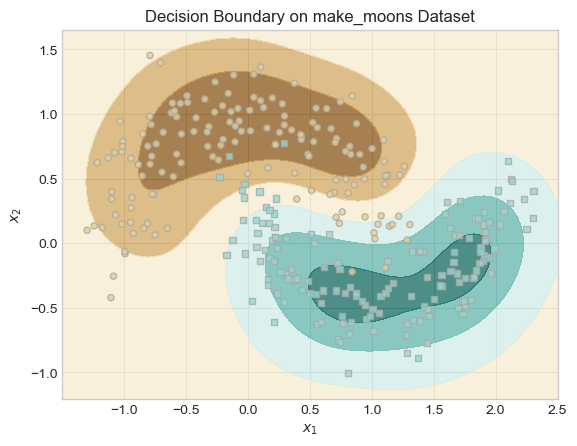

In [18]:
x1 = torch.linspace(X_moons[:,0].min() - 0.2, X_moons[:,0].max() + 0.2, 101)
x2 = torch.linspace(X_moons[:,1].min() - 0.2, X_moons[:,1].max() + 0.2, 101)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

X_grid = torch.stack((X1.ravel(), X2.ravel()), dim=1)
preds = KR_moons.score(X_grid, recompute_kernel=True)
preds = torch.sigmoid(preds).reshape(X1.shape)

fig, ax = plt.subplots()
ax.contourf(X1, X2, preds, cmap="BrBG", alpha=0.7)
plot_classification_data(X_moons, y_moons, ax)
plt.title("Decision Boundary on make_moons Dataset")

## Part B

### Demonstrating Overfitting
In our code below we generated two datasets one for training and the other for testing. We then trained our model with a bad Gamma so that we can cause overfitting. By setting our gamma high to somewhere around 5-10 we force the model to overfit.


In [31]:
# Training data
X_train_np, y_train_np = make_moons(n_samples=300, noise=0.4)
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

# Testing data
X_test_np, y_test_np = make_moons(n_samples=300, noise=0.4)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

#Training our model
KR_overfit = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=5)
KR_overfit.fit(X_train, y_train, m_epochs=500000, lr=0.0001)



Now that we have trained our model, we will now evaluate our model and get predictions on teh train and test set. 

### Plotting our ROC curve

In our plot The training ROC curve is very close to the top-left (meaning high performance), while the test ROC curve is much lower, indicating poor generalization.

This large gap between the training and testing performance means our model is overfitting. The model fits the noise in the training data instead of learning a decision boundary that generalizes the new examples/ test data.


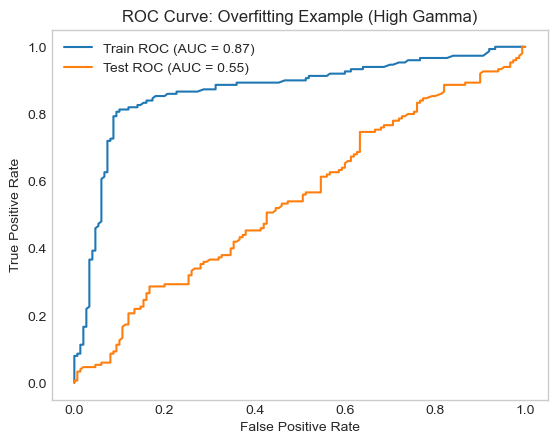

In [32]:
from sklearn.metrics import roc_curve, auc


# predicting on the training data and the test data
train_scores = torch.sigmoid(KR_overfit.score(X_train)).detach().numpy()
test_scores = torch.sigmoid(KR_overfit.score(X_test)).detach().numpy()


# calculate the ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc(fpr_train, tpr_train):.2f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc(fpr_test, tpr_test):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Overfitting Example (High Gamma)")
plt.legend()
plt.grid()
plt.show()


## Conclusion

In this project, I built a Sparse Kernal Machine which is  version of logistic regression that encourages sparsity. I tested how different settings of λ and γ affect the model's behavior. 

I learned that using a large λ makes the model sparse by reducing the number of important training points. I also learned that adjusting γ changes how flexible the decision boundary is: small γ values make smoother boundaries, while large γ values create more complex ones. 

Lastly, I saw how using a high γ can cause the model to overfit, doing well on training data but poorly on new testing data. Overall, this project helped me better understand how regularization and kernel methods work together to affect model complexity and generalization.
